# Support Vector Machines - IIC2613

In this notebook we will build from scratch a simple version of an SVM for a binary classification problem. We will not be using $\texttt{sklearn}$ to program this, only $\texttt{numpy}$.

## Dataset Creation

We will create a fake dataset that should be quite separable linearly!

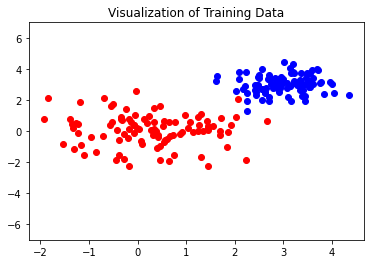

In [1]:
!pip -q install celluloid # Just to create animations!
# Create a dataset
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.core.display import Video
import celluloid

size = 100
train_data = []
test_data = []
labels = [-1 for i in range(size)] # Negative samples
labels += [1 for i in range(size)] # Positive samples

# We will want to predict points taken from a multivariate normal distribution
mu = [[0,0], [3.0,3.0]]                  # Means
std = [[[1,0],[0,1]],[[1/3,0], [0,1/3]]] # Covariance Matrices

# Create train data
for i in range(len(mu)):
    train_data += list(np.random.multivariate_normal(mu[i],std[i],size))

train_data = np.array(train_data)
train_data = np.c_[ train_data, np.ones(2*size) ]

# Create test data
for i in range(len(mu)):
    test_data += list(np.random.multivariate_normal(mu[i],std[i],size))

test_data = np.array(test_data)
test_data = np.c_[ test_data, np.ones(2*size) ]

# Plot data!
# Plot initial conditions!
fig, ax = plt.subplots()
ax.set_ylim([-7, 7])
plt.title("Visualization of Training Data")
plt.scatter([x[0] for x in train_data[:size]],[x[1] for x in train_data[:size]],color="red")
plt.scatter([x[0] for x in train_data[size:]],[x[1] for x in train_data[size:]],color="blue")
plt.show()

In [2]:
# This function will return how poorly our current hypothesis fits the data!
def funcion_costo(X,Y, params,C=1):
    norm = (params**2).sum()        # 1. Squared norm of parameters
    dist = 1 - Y*np.dot(X,params)   # 2. How much we are currently inside the max margin for every point!
    dist = dist[dist>0]             # We only care about distances that are greater than 0,
                                    # because that means either:
                                    # a) We are correctly classified but our margin is less than 1 --> (0 < 1 - Y * <X,w> < 1).
                                    # b) We are incorrectly classified (Y*<x, w> < 0)
    return norm/2, C*dist.sum(), norm/2+C*dist.sum()

## Optimization

Instead of finding the solution by optimizing using Lagrange multipliers, we are going to solve it using *Gradient Descent* (GD). In GD, we iteratively update our parameters by moving them either in the **direction of the gradient** of the function we want to maximize or against it if we want to minimize it. Thus:

$$\vec{w}^{(t+1)} = \vec{w}^{(t)} - \mu \cdot \nabla c(\vec{w}^{(t)})$$

Where $\mu$ is just a scalar value which represents a step size for our gradient step. In our case, we have that:

$$c(w) =  \frac{1}{2}||\vec{w}||^2 + C*\sum \limits_{i=1}^{n}(1-y_i*<\vec{x_i},\vec{w}>)$$

Differentiating $c(\vec{w})$ with respect to $\vec{w}$:

$$\nabla c(\vec{w}) = \vec{w} - C\sum \limits_{i=1}^{n} y_i \cdot \vec{x_i} $$

In [3]:
# This function calculates the gradient of our cost function with respect to 
# our parameters
def calcular_gradiente(X,Y,params,C=1):
    grad_margin = params
    dist = 1 - Y*np.dot(X,params)
    valid_sample = (dist>0).astype(float) # We only consider a sample if it is within margin or incorrectly classified
    valid_sample = np.expand_dims(valid_sample,axis=1).repeat(3,axis=1)
    Y = np.expand_dims(Y,axis=1).repeat(3,axis=1)
    grad_clas = -valid_sample*Y*X

    return grad_margin+C*grad_clas.sum(axis=0)

## Training our SVM with Gradient Descent

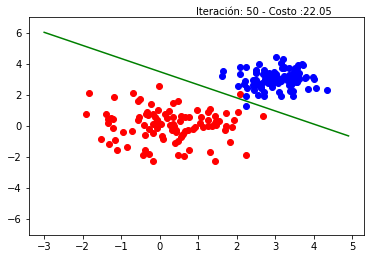

In [4]:
iterations = 50         # Number of iterations we will take
delta = 0.005           # Step size for each iteration in Gradient Descent
C=10                    # How much we value satisfying our margin constraints 
params = np.array([-1, 1, 1]).astype(float)  # Our hyperplane! We want to find its
                                             # optimal values!

# Plot initial conditions!
x_line = np.arange(-3,5,0.1)
line = [-(params[-1] + x*params[0])/params[1] for x in x_line]
fig, ax = plt.subplots()
ax.text(0.5, 1.01, f"Iteración: 0 - Costo :{funcion_costo(train_data, labels, params)[-1]:.2f}", transform=ax.transAxes)
ax.set_ylim([-7, 7])
camera = Camera(fig)
plt.scatter([x[0] for x in train_data[:size]],[x[1] for x in train_data[:size]],color="red")
plt.scatter([x[0] for x in train_data[size:]],[x[1] for x in train_data[size:]],color="blue")
plt.plot(x_line, line, color = "green")
camera.snap()

# Train our SVM
for iteration in range(1,iterations+1):

    # Calculate gradient!
    grad = calcular_gradiente(train_data,labels, params,C=C)
    # Gradient Descent step!
    params -= delta*grad
    # Get updated performance metrics
    norma, dist, total = funcion_costo(train_data, labels, params)
    
    # Plot new hyperplane!
    line = [-(params[-1] + x*params[0])/params[1] for x in x_line]
    ax.text(0.5, 1.01, f"Iteración: {iteration} - Costo :{total:.2f}", transform=ax.transAxes)
    plt.scatter([x[0] for x in train_data[:size]],[x[1] for x in train_data[:size]],color="red")
    plt.scatter([x[0] for x in train_data[size:]],[x[1] for x in train_data[size:]],color="blue")
    plt.plot(x_line, line, color = "green")
    camera.snap()
# Create final animation!
anim = camera.animate(blit=True)
anim.save("result.mp4")

Video("result.mp4", embed=True)

## Evaluation

We will now evaluate our final model in both our training and test sets, to check its performance.

### Training Set

In [29]:
# Compute predictions for our model
preds = np.dot(train_data, params)>0
correct = preds == (np.array(labels) > 0)
accuracy = correct.astype(int).sum()/correct.shape[0]
print(f"Training Accuracy: {100*accuracy}%")

Training Accuracy: 100.0%


### Test Set

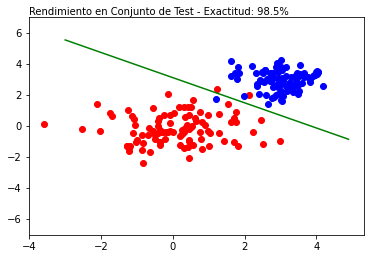

In [30]:
# Compute predictions for our model
preds = np.dot(test_data, params)>0
correct = preds == (np.array(labels) > 0)
accuracy = correct.astype(int).sum()/correct.shape[0]

# Plot our hyperplane with test data!
x_line = np.arange(-3,5,0.1)
line = [-(params[-1] + x*params[0])/params[1] for x in x_line]
fig, ax = plt.subplots()
ax.text(0.0, 1.01, f"Rendimiento en Conjunto de Test - Exactitud: {100*accuracy}%", transform=ax.transAxes)
ax.set_ylim([-7, 7])
plt.scatter([x[0] for x in test_data[:size]],[x[1] for x in test_data[:size]],color="red")
plt.scatter([x[0] for x in test_data[size:]],[x[1] for x in test_data[size:]],color="blue")
plt.plot(x_line, line, color = "green")
plt.show()